In [105]:
import pandas as pd
import numpy as np
import os
import re
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [106]:
# Let's set up the working directory
os.chdir("C:/Users/artur/Desktop")

# Data preparation to model plant species distribution in the Brazilian Caatinga dry forest

This project is part of an academic reasearch in which I am collaborating. The research involves [Dr. Bruno Pinho](https://www.researchgate.net/profile/Bruno_Pinho3), [Professor Marcelo Tabarelli](https://www.researchgate.net/profile/Marcelo_Tabarelli) (both from the Federal University of Pernambuco - Brazil) and [Professor Carlos Peres](https://www.researchgate.net/profile/Carlos_Peres), from the University of East Anglia - United Kingdom.

The goal of this academic research is to understand the extent to which plant species from the Brazilian Caatinga dry forest are threatened by climate change and human activities. To reach this goal, we will build a predictive model to predict which flora (in terms of species number and composition) we can expect, given specific climate and human disturbance conditions. 

The dataset we will use in this research contains geographic coordinates of 940 species of trees and shrubs distributed in the Brazilian Caatinga dry forest. The area of the Caatinga is 850,000 km<sup>2</sup>, which comprises most of Northeast Brazil [see the Caatinga distribution here](https://pt.wikipedia.org/wiki/Caatinga). To model the Caatinga flora, we need to group nearby geographic coordinates into grids of 50 km2 (0.5 degrees of longitude by 0.5 degrees of latitude). The 50 km<sup>2</sup> grids will be the observational units of the study from which we will extract information of species number/composition and levels of precipitation and human disturbance. As precipitation and human disturbance values will be extracted (latter on the research) from  the centre of each grid cell (grid centroid), we also need to add to our dataset the geographic coordinates of each grid centroid. 

Below is an illustration of the information contained in the raw dataset (circles of different colors represent different species):

<img src="map_1.png" width=500 style="height:350px">


Here, we will perform some data manipulation to convert the raw data we have into a dataset appropriate to build a predictive model. Specifically we will group the geographic occurrences of the 940 species in our dataset into 50 km<sup>2</sup> bins. 

After this project, this will be the information contained in the dataset:

<img src="map_2.png" width=500 style="height:350px">

Along this project we will:

- Write the `to_bin` function to create 50 km<sup>2</sup> bins (the grid cells)
- Use `map(to_bin)` on the geographic coordinates to create bins of 50 km<sup2</sup> (grid cells)
- Calculate the geographic coordinates of the center of each grid cell (centroids)
`pandas.DataFrame.groupby` to group the species occurrences into the grid cells
- `pandas.DataFrame.pivot` to convert dataset into a species abundance matrix. where each column is a plant species and each row is a grid cell. 
- Perform some data cleaning to standardize plant names
- `pandas.DataFrame.merge
- String manipulation: string `format()` and regex
- `for` loop and `zip()`function to rename hundreds of column labels at once
- Use the Matplotlib Basemap Toolkit to plot the geographic variation in species number throughout the Caatinga dry forest.

# Part I: Grouping geographic occurrences of plant species into grid cells

# Loading the dataset and taking a look at it

First, let's import the dataset.

In [107]:
# Importing the dataset
df=pd.read_csv("df_ClimData.csv",sep=';',engine='python')
df.head()

,Unnamed: 0,Species,Longitude,Latitude,Temp,annual_prec,prec_dryest,prec_seas
0,1,Abarema langsdorffii (Benth.) Barneby & J.W.Gr...,-42.11,-16.91,239,844,4,88
1,2,Acanthocladus albicans A.W.Benn.,-43.02,-15.13,230,845,1,91
2,3,Acanthocladus albicans A.W.Benn.,-42.20,-13.43,228,784,2,89
3,4,Acanthocladus albicans A.W.Benn.,-42.21,-13.24,228,831,2,87
4,5,Acanthocladus albicans A.W.Benn.,-37.50,-10.54,238,939,32,57


In [108]:
# Taking a look at the dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14655 entries, 0 to 14654
Data columns (total 8 columns):
Unnamed: 0     14655 non-null int64
Species        14655 non-null object
Longitude      14655 non-null float64
Latitude       14655 non-null float64
Temp           14655 non-null int64
annual_prec    14655 non-null int64
prec_dryest    14655 non-null int64
prec_seas      14655 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 916.0+ KB


As we can see, the dataset contains 8 columns and no missing data.
We are interested in three columns only, which are: `Species`, `Longitude`, and `Latitude`. 
Let's slice the dataset to keep only these three columns.

In [109]:
# Slicing the dataset 
df=df.loc[:,['Species','Longitude','Latitude']]
df.head()

,Species,Longitude,Latitude
0,Abarema langsdorffii (Benth.) Barneby & J.W.Gr...,-42.11,-16.91
1,Acanthocladus albicans A.W.Benn.,-43.02,-15.13
2,Acanthocladus albicans A.W.Benn.,-42.20,-13.43
3,Acanthocladus albicans A.W.Benn.,-42.21,-13.24
4,Acanthocladus albicans A.W.Benn.,-37.50,-10.54


## Writing the `to_bin` function to create 50 km<sup>2</sup> bins, the map grid

Now we will build a function called `to_bin`, which was extracted from [Stack Overflow](https://stackoverflow.com/questions/39254704/pandas-group-bins-of-data-per-longitude-latitude). `to_bin` will round longitude and latitude values to one decimal case in 0.5 unit (decimal degree) intervals. For instance, a longitude value of -42.11 will be rounded to -42.5, whereas a value of -42.63 will be rounded to -43.0. We will use the `to_bin` function for latitude too. 

Latter, we will pass `to_bin` on the geographic coordinates (both longitude and latitude) so that longitude and latitude values  different in less than 0.5 decimal degree will be assigned to the same geographic bin of 50 km<sup>2</sup>. 
 

In [110]:
# Creating the to_bin function to make grids
grid_size=0.5
to_bin=lambda x:np.floor(x/grid_size)*grid_size

In [111]:
# Here is a simple example to show how to_bin function works
x=np.array([0.31,0.49,0.50,0.78,1.35])
to_bin(x)

array([0. , 0. , 0.5, 0.5, 1. ])

## Creating geographic bins of 50 km<sup>2</sup> (grid cells)

As mentioned above, we will use `map()` to pass `to_bin` on `Longitude` and `Latitude` columns and store the output in two new columns, `long_grid` and `lat_grid`. The values in `long_grid` and `lat_grid` will be the coordinates of the lower left corner of each grid cell. This is equivalent to split the geographic area in which species occurrences are distributed into grids of 50 km<sup>2</sup> (see figures on the top).

In [112]:
# Creating the long_grid and lat_grid columns
df['long_grid']=df['Longitude'].map(to_bin)
df['lat_grid']=df['Latitude'].map(to_bin)
df.head()

,Species,Longitude,Latitude,long_grid,lat_grid
0,Abarema langsdorffii (Benth.) Barneby & J.W.Gr...,-42.11,-16.91,-42.5,-17.0
1,Acanthocladus albicans A.W.Benn.,-43.02,-15.13,-43.5,-15.5
2,Acanthocladus albicans A.W.Benn.,-42.20,-13.43,-42.5,-13.5
3,Acanthocladus albicans A.W.Benn.,-42.21,-13.24,-42.5,-13.5
4,Acanthocladus albicans A.W.Benn.,-37.50,-10.54,-37.5,-11.0


## Calculating the centroids of the grid cells 

The grid cells are our observational units, therefore to build a predictive model of the flora of the Brazilin Caatinga we need the species number and composition in each grid cell, and also the levels of precipitation and human disturbances within each grid cell. One way to obtain aproximated values of precipitation and human disturbance for each grid cell is to extract georreferenced data from the central point of each grid cell (centroid). 
 
To calculate the centroid we simply add 0.25 to the longitude and latitude values of each grid cell (see figure below).

<img src="map_3.png" width=500 style="height:350px">

In [113]:
# Calculating the centroids of the grid cells
df['centroid_long']=df['long_grid']+0.25
df['centroid_lat']=df['lat_grid']+0.25
df.head()

,Species,Longitude,Latitude,long_grid,lat_grid,centroid_long,centroid_lat
0,Abarema langsdorffii (Benth.) Barneby & J.W.Gr...,-42.11,-16.91,-42.5,-17.0,-42.25,-16.75
1,Acanthocladus albicans A.W.Benn.,-43.02,-15.13,-43.5,-15.5,-43.25,-15.25
2,Acanthocladus albicans A.W.Benn.,-42.20,-13.43,-42.5,-13.5,-42.25,-13.25
3,Acanthocladus albicans A.W.Benn.,-42.21,-13.24,-42.5,-13.5,-42.25,-13.25
4,Acanthocladus albicans A.W.Benn.,-37.50,-10.54,-37.5,-11.0,-37.25,-10.75


# Part II: Convert the dataset into a matrix of species abundance

To build a predictive model of the Caatinga flora, it is important to know how many times each species was recorded in each grid cell. In other words, we need to know the abundance of each species in each grid cell. The best way to store this information is in a species abundance matrix. A species abundance matrix is a dataset in which each row corresponds to a grid cell, and the columns contains the abundance of each species in each grid cell. See below an illustrative description of a species abundance matrix.

Here is how the species occurrence are geographically distributed:
<img src="map_2.png" width=500 style="height:350px">

Here is how a species abundance matrix stores the species occurence information described in the illustration above:
<img src="sp_abund_matr_ex.png" width=500 style="height:350px">

Let's convert our current dataset into a species abundance matrix.

## First step: converting rows into columns with `pandas.DataFrame.pivot`

The first step is to pivot the dataset using `pandas.DataFrame.pivot`. After pivoting, each of the plant species names in the `Species` column will become a column. 

In [114]:
# Pivoting the dataset so that species are columns
df_pivot=df.pivot(columns='Species',values='Longitude')
df_pivot.head()

Species,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,Acosmium lentiscifolium Schott,Acrocomia aculeata (Jacq.) Lodd. ex Mart.,Actinostemon concolor (Spreng.) Müll.Arg.,Adelia membranifolia (Müll.Arg.) Chodat & Hassl.,Aegiphila integrifolia (Jacq.) B.D.Jackson,Aegiphila verticillata Vell.,Aegiphila vitelliniflora Walp.,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,-42.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-43.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-42.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-42.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-37.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that we passed the `Longitude` column as the argument of the `values` parameter of `pivot()`. We could also have used the `Latitude` column instead. Also, notice the we have lost the columns containing geographic information. We will retrieve them latter.

Now, let's fill `NaN` values with zero.

In [115]:
# Filling NaN values with 0
df_pivot=df_pivot.fillna(0)
df_pivot.head()

Species,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,Acosmium lentiscifolium Schott,Acrocomia aculeata (Jacq.) Lodd. ex Mart.,Actinostemon concolor (Spreng.) Müll.Arg.,Adelia membranifolia (Müll.Arg.) Chodat & Hassl.,Aegiphila integrifolia (Jacq.) B.D.Jackson,Aegiphila verticillata Vell.,Aegiphila vitelliniflora Walp.,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,-42.11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,-43.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,-42.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,-42.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,-37.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Second step: Using `lambda` function to convert the data set into a binary matrix

As we said before, each row of a species abundance matrix corresponds to a grid cell. Therefore, each non-zero value of our dataset means that the species was recorded in that grid cell. 

Let's convert each non-zero value of our dataset into `1`. This way `1` will represent species presence and `0` species absence in a given grid cell.

In [116]:
# Turning the dataset into a binary matrix
df_pivot=df_pivot.applymap(lambda x: 1 if x<0 else 0)
df_pivot.head()

Species,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,Acosmium lentiscifolium Schott,Acrocomia aculeata (Jacq.) Lodd. ex Mart.,Actinostemon concolor (Spreng.) Müll.Arg.,Adelia membranifolia (Müll.Arg.) Chodat & Hassl.,Aegiphila integrifolia (Jacq.) B.D.Jackson,Aegiphila verticillata Vell.,Aegiphila vitelliniflora Walp.,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Step 3: retrieving the geographic data using `pandas.DataFrame.merge`

As we mentioned before, when we pivoted the dataset, we lost the columns containing geographic data.

Now, we need to bring back the geographic information to the dataset. We will do so using `pandas.DataFrame.merge`. 

Specifically, we will merge the geographic columns of our original dataset with the pivoted dataset by their indexes. 

In [117]:
df_merge=pd.merge(df,df_pivot,left_index=True,right_index=True)
df_merge.head()

,Species,Longitude,Latitude,long_grid,lat_grid,centroid_long,centroid_lat,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,Abarema langsdorffii (Benth.) Barneby & J.W.Gr...,-42.11,-16.91,-42.5,-17.0,-42.25,-16.75,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acanthocladus albicans A.W.Benn.,-43.02,-15.13,-43.5,-15.5,-43.25,-15.25,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Acanthocladus albicans A.W.Benn.,-42.20,-13.43,-42.5,-13.5,-42.25,-13.25,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Acanthocladus albicans A.W.Benn.,-42.21,-13.24,-42.5,-13.5,-42.25,-13.25,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Acanthocladus albicans A.W.Benn.,-37.50,-10.54,-37.5,-11.0,-37.25,-10.75,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Step 4: Using `pandas.DataFrame.groupby` to build the species abundance matrix

Our goal is that each row correspond to a grid cell and each column correspond to the species abundance per grid cell. Since we have one centroid per grid cell, each row of our species abundance matrix can be represented by either a grid cell or a centroid. As mentioned before, in a latter stage of our research (not coverd here) we will extract georreference data on precipitation and human disturbance based on the geographic coordinates of each centroid. Therefore, it is more practical to set centroids as the rows of our dataset. 

Because two or more centroids can share either longitude or latitude, it will be easier to group our data by unique centroids if we concatenate the `centroid_long` and `centroid_lat` columns. This way, we will have a column to group our data by unique centroids.

Let's create the `centroid` column.

In [118]:
# Concatenating the longitude and latitude of the centroids into a single column 
df_merge['centroid']=df_merge['centroid_long'].map(str)+df_merge['centroid_lat'].map(str)
df_merge['centroid'].head()

0    -42.25-16.75
1    -43.25-15.25
2    -42.25-13.25
3    -42.25-13.25
4    -37.25-10.75
Name: centroid, dtype: object

Now we can finally create a species abundance matrix using `pandas.DataFrame.groupby`. Remember that our goal here is to build a species abundance matrix in which each row corresponds to a centroid and each column correspond to a species. The cells of this matrix will be filled by the number of times a species was observed in each centroid.

In [119]:
# Creating the species abundance matrix
n_cols=df_merge.iloc[:,7:-1].columns.tolist() 
spp_by_centroid=df_merge.groupby(['centroid'])[n_cols].sum()
spp_by_centroid.reset_index(inplace=True)
spp_by_centroid.head()

,centroid,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,Acosmium lentiscifolium Schott,Acrocomia aculeata (Jacq.) Lodd. ex Mart.,Actinostemon concolor (Spreng.) Müll.Arg.,Adelia membranifolia (Müll.Arg.) Chodat & Hassl.,Aegiphila integrifolia (Jacq.) B.D.Jackson,Aegiphila verticillata Vell.,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,-35.75-6.75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
1,-35.75-7.25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,1,0
2,-36.25-7.25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,-36.25-7.75,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
4,-36.25-8.25,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0


We concatenated the `centroid_long` and `centroid_lat` columns to group species occurrences by centroid. However, to perform analyses latter, it is better to have longitude and latitudes of the centroids in separate columns. 

Let's split the `centroid` column.

In [120]:
# Spliting the centroid column and making it of float values again
spp_by_centroid['centroid_long']=spp_by_centroid['centroid'].str.split('-').str.get(1).astype('float')
spp_by_centroid['centroid_lat']=spp_by_centroid['centroid'].str.split('-').str.get(2).astype('float')
spp_by_centroid['centroid_long']=spp_by_centroid['centroid_long']*-1
spp_by_centroid['centroid_lat']=spp_by_centroid['centroid_lat']*-1
spp_by_centroid=spp_by_centroid.reset_index()
spp_by_centroid.drop(columns='centroid',inplace=True)
spp_by_centroid=spp_by_centroid.rename(columns={'index':'centroid'})

# Reordering the columns
cols=spp_by_centroid.columns.tolist()
cols=cols[:1]+cols[-2:]+cols[1:-2]
spp_by_centroid=spp_by_centroid[cols]
spp_by_centroid.head()

,centroid,centroid_long,centroid_lat,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,Acosmium lentiscifolium Schott,Acrocomia aculeata (Jacq.) Lodd. ex Mart.,Actinostemon concolor (Spreng.) Müll.Arg.,Adelia membranifolia (Müll.Arg.) Chodat & Hassl.,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,0,-35.75,-6.75,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
1,1,-35.75,-7.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,1,0
2,2,-36.25,-7.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,3,-36.25,-7.75,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
4,4,-36.25,-8.25,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0


# Part III: Data cleaning and string manipulation

## String `format()`

To make the dataset easier to read, let's add the string "centroid_" before the current numeric values in the `centroid` column. 

In [121]:
# Numbering the centroids
spp_by_centroid['centroid']=spp_by_centroid['centroid'].map(lambda x: 'centroid_{}'.format(x+1))
spp_by_centroid.head()

,centroid,centroid_long,centroid_lat,Abarema langsdorffii (Benth.) Barneby & J.W.Grimes,Acanthocladus albicans A.W.Benn.,Acosmium diffusissimum (Mohlenbr.) Yakovlev,Acosmium lentiscifolium Schott,Acrocomia aculeata (Jacq.) Lodd. ex Mart.,Actinostemon concolor (Spreng.) Müll.Arg.,Adelia membranifolia (Müll.Arg.) Chodat & Hassl.,...,Zanthoxylum stelligerum Turcz.,Zanthoxylum syncarpum Tul.,Zanthoxylum tingoassuiba A.St.-Hil.,Zapoteca portoricensis (Jacq.) H.M.Hern.,Zeyheria tuberculosa (Vell.) Bureau,Ziziphus cotinifolia Reissek,Ziziphus joazeiro Mart.,Ziziphus platyphylla Reissek,Zollernia paraensis Huber,Zygia latifolia (L.) Fawc. & Rendle
0,centroid_1,-35.75,-6.75,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
1,centroid_2,-35.75,-7.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,1,0
2,centroid_3,-36.25,-7.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,centroid_4,-36.25,-7.75,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
4,centroid_5,-36.25,-8.25,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0


## Regex

The species names are accompanied by the names of the botanists that described the species. For instance, in Acosmium lentiscifolium Schott, Schott is the name of the botanist that described the plant species Acosmium lentiscifolium. 

Since we do not need authors' names, let's drop these names to make our datasets cleaner.

First, we will convert the labels of the species columns into a list of strings.

In [122]:
# Converting the labels of the species columns into a list of strings
lista_spp=spp_by_centroid.iloc[:,3:].columns.tolist() 
lista_spp=pd.Series(lista_spp)
lista_spp.head()

0    Abarema langsdorffii (Benth.) Barneby & J.W.Gr...
1                     Acanthocladus albicans A.W.Benn.
2          Acosmium diffusissimum (Mohlenbr.) Yakovlev
3                       Acosmium lentiscifolium Schott
4            Acrocomia aculeata (Jacq.) Lodd. ex Mart.
dtype: object

Now, we will use regex to extract only the species names without the botanist names. 

In [123]:
# Using regex to remove the botanist names  
pattern=r'(\w*\s\w*)'
lista_spp=lista_spp.str.extract(pattern)
lista_spp=lista_spp.iloc[:,0].str.replace(' ','_').str.strip()
lista_spp.head()

0       Abarema_langsdorffii
1     Acanthocladus_albicans
2     Acosmium_diffusissimum
3    Acosmium_lentiscifolium
4         Acrocomia_aculeata
Name: 0, dtype: object

## Renaming hundreds of column names using `for` loop and `zip()` function

Now that we have cleaned the plant species names, we need to rename the column labels with the new species name format.

We will do so using `for` loop and `zip()` function to populate an empty dictionary with old column labels (species names and botanist names) as keys and new column labels (only species names) as values.

Then, we will pass the dictionary into the `pandas.DataFrame.rename`function to rename the species columns.

In [124]:
# Building a dictionary with old column labels as keys and new column labels as values
dic_cols={}
old_cols=spp_by_centroid.iloc[:,3:].columns.tolist()
new_cols=lista_spp.values.tolist()

for x,y in zip(old_cols,new_cols):
    dic_cols[x]=y
dic_cols

{'Abarema langsdorffii (Benth.) Barneby & J.W.Grimes': 'Abarema_langsdorffii',
 'Acanthocladus albicans A.W.Benn.': 'Acanthocladus_albicans',
 'Acosmium diffusissimum (Mohlenbr.) Yakovlev': 'Acosmium_diffusissimum',
 'Acosmium lentiscifolium Schott': 'Acosmium_lentiscifolium',
 'Acrocomia aculeata (Jacq.) Lodd. ex Mart.': 'Acrocomia_aculeata',
 'Actinostemon concolor (Spreng.) Müll.Arg.': 'Actinostemon_concolor',
 'Adelia membranifolia (Müll.Arg.) Chodat & Hassl.': 'Adelia_membranifolia',
 'Aegiphila integrifolia (Jacq.) B.D.Jackson': 'Aegiphila_integrifolia',
 'Aegiphila verticillata Vell.': 'Aegiphila_verticillata',
 'Aegiphila vitelliniflora Walp.': 'Aegiphila_vitelliniflora',
 'Agonandra brasiliensis Miers ex Benth. & Hook.': 'Agonandra_brasiliensis',
 'Agonandra excelsa Griseb.': 'Agonandra_excelsa',
 'Albizia inundata (Mart.) Barneby & J.W.Grimes': 'Albizia_inundata',
 'Albizia niopoides (Spruce ex Benth.) Burkart': 'Albizia_niopoides',
 'Albizia polycephala (Benth.) Killip': 'Al

In [125]:
# Renaming species column labels
spp_by_centroid=spp_by_centroid.rename(columns=dic_cols)
spp_by_centroid.head()

,centroid,centroid_long,centroid_lat,Abarema_langsdorffii,Acanthocladus_albicans,Acosmium_diffusissimum,Acosmium_lentiscifolium,Acrocomia_aculeata,Actinostemon_concolor,Adelia_membranifolia,...,Zanthoxylum_stelligerum,Zanthoxylum_syncarpum,Zanthoxylum_tingoassuiba,Zapoteca_portoricensis,Zeyheria_tuberculosa,Ziziphus_cotinifolia,Ziziphus_joazeiro,Ziziphus_platyphylla,Zollernia_paraensis,Zygia_latifolia
0,centroid_1,-35.75,-6.75,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
1,centroid_2,-35.75,-7.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,1,0
2,centroid_3,-36.25,-7.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,centroid_4,-36.25,-7.75,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
4,centroid_5,-36.25,-8.25,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0


# Part IV: Ploting the data

## Counting species number per grid cell

The last part of this project is to visualize in a map the number of species in each grid cell. 

First, we need to count the number of species in each row, which represent the grid cells we created in the steps above.

Remember that to facilitate the aquisition of precipitation and human disturbance data (this part is not covered here), the geographic position of the grid cells is represented by the coordinates of their centroids.

To count the number of species per row in our dataset, we will use `gt()`, wich stands for greater than, to sum the number of non-zero values in each row.

In [126]:
spp_by_centroid['species_number']=spp_by_centroid.iloc[:,3:].gt(0).sum(axis=1)
spp_by_centroid['species_number'].head()

0    85
1    77
2    89
3    87
4    86
Name: species_number, dtype: int64

## Ploting species number per centroid

To plot species number per grid cell, we will use Basemap, and extension of Matplotlib very useful to work with geographic data.

First, let's define the geographic range in which our data will be ploted.

In [127]:
min_lat=spp_by_centroid['centroid_lat'].min() # This code sets the latitude of the lower left corner of the map we will plot.
print(min_lat)

min_long=spp_by_centroid['centroid_long'].min() # This code sets the longitude of the lower left corner of the map.  
print(min_long)

max_lat=spp_by_centroid['centroid_lat'].max() # This code sets the latitude of the upper right corner of the map.
print(max_lat)

max_long=spp_by_centroid['centroid_long'].max() # This code sets the longitude of the upper right corner of the map.
print(max_long)

-17.25
-45.25
-4.25
-35.75


Now we can create our map and plot the total number of species per grid cell using colormap `cmap`.

C:\Users\artur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


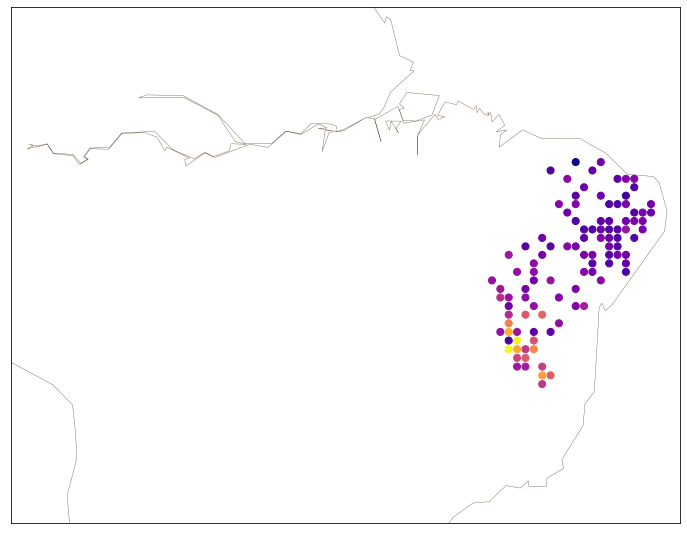

In [128]:
# Plotting the total number of species per drid cell
fig=plt.figure(figsize=(12,12))
m=Basemap(projection='merc',llcrnrlat=-25,urcrnrlat=5,llcrnrlon=-74,urcrnrlon=-34)
m.drawcoastlines(color='#6D5F47', linewidth=.4)
long=spp_by_centroid['centroid_long'].tolist()
lat=spp_by_centroid['centroid_lat'].tolist()
x,y=m(long,lat)
m.scatter(long,lat,s=50,zorder=2,latlon=True, c=spp_pa['species_number'],cmap='plasma')
plt.show()

The warmer colors filling the points in the map indicate greater species numbers. Therefore, the Southern grid cells are richer in species than the Northern ones, suggesting the Southern portion of the Caatinga dry forest is of greater biological importance.

# Next steps

Now that we have prepared our dataset creating a species abundance matrix, we are ready to move on our research and build a predictive model of the flora of the Brazilian Caatinga dry forest to predict how the vegetation of this region will respond to global warming and human disturbances. 